## Tutorial for Astropy's Photutils Package

Elvira Cruz-Cruz

Examples were gathered and used from Photutils' documentation site --> https://photutils.readthedocs.io/en/stable/index.html

In [1]:
import photutils
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

# matplotlib settings 
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

### Introduction to Photutils
Photutils is an Astropy Package for detecting astronomical objects in images and performing photometry. It's important to perform photometry on images because through photometry we measure the amount of light from the astronomical source of interest. This is done by measuring the flux of the source by summing all the light recorded from the object and subtracting the light due to the sky. 

Before performing photometry, first the astronomical sources need to be found in the data/image first. Photutils takes care of Source Detection by including two tools for detecting stars in an image:

##### 1. DAOFIND
##### 2. IRAF's Starfind

There are two ways of measuring the light or flux from a source, i.e., performing photometry on an image:

##### 1. Aperture Photometry 
##### 2. Point Spread Function (PSF) Photometry

Photutils contains classes that execute these methods to detect one or more sources in an image and measure the flux distributions of these astronomical objects and hence measure the brightness of these objects. 

The "high-level" classes that piece together the classes that perform sub-tasks of PSF Photometry are: 

##### 1. BasicPSFPhotometry 
##### 2. IterativelySubtractedPSFPhotometry
##### 3. DAOPhotPSFPhotometry 

The package supports image files such as IRAF, FITS, WCS, and ds9, etc. 

NOTE: The pixel coordinate convention that is used in photutils is different than that in the image file formats that are mentioned earlier. The pixel coordinates are identified as x and y coordinates: 
- the x (column) coordinate corresponds to the second array index
- the y (row) coordinate corresponds to the first array index
- $\bf{Syntax}$ $\bf{Example:}$ When you only want a section of the image you, you need to call array ranges of x-coord pixels and y-coord pixels. 
    - $\bf{image[y,x]}$ which gives you the value at $\bf{pixel}$ $\bf{coordinates}$ $\bf{(x,y)}$


### (Complete) Functions of Photutils

- Performing aperture photometry
- Performing PSF-fitting photometry
- Detecting and Extracting point-like sources (like stars) in images
- Centroiding Sources
- Estimating the background and background RMS in images
- Building an effective Point Spread Function (ePSF)
- Matching PSF Kernels 
- Estimating morphological parameters of detected sources 



### Example 
#### Finding sources in astronomical image.

The image that is used for this example is from the pre-installed photutils datasets. 

In this example, they work with a FITS file image of the open cluster, M67.

M67's Image Pixel Size: (1059, 1059) pixels


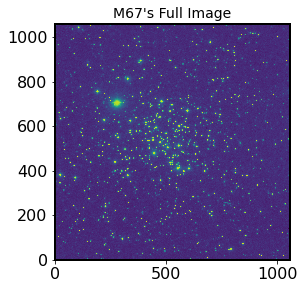

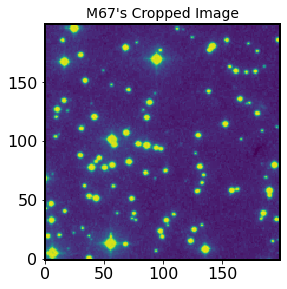

In [2]:
from photutils.datasets import load_star_image

## Loading M67's full image
# load_star_image() --> loads an example image of M67 (Open Cluster) 
# hdu is a FITS ImageHDU object
# hdu.data is an ndarray object

hdu = load_star_image()
print("M67's Image Pixel Size:", hdu.data.shape, 'pixels')
plt.imshow(hdu.data, origin='lower', interpolation='nearest')
plt.tight_layout()
plt.title("M67's Full Image")
plt.show()


# Loading a subset of M67's image 
## --> getting a section of the image
### hdu.data[y,x] : gives the value at pixel coordinates (x,y)
section_image = hdu.data[500:700, 500:700].astype(float)
plt.imshow(section_image, origin='lower', interpolation='nearest')
plt.tight_layout()
plt.title("M67's Cropped Image")
plt.show()

# 'nearest' interpolation is used if the image is upsampled by more than a factor of three 
# (i.e. the number of display pixels is at least three times the size of the data array)

Then subtract a rough estimate of the background. This amount of the background contibution is calculated using image median:

In [3]:
section_image -= np.median(section_image)

In the remainder of this example, it is assumed that the data is background subtracted.

Photutils supports several source detection algorithms. 

Example: Photutils uses $DAOStarFinder$ to detect the stars in the image. In this example, they use the detection threshold at the 3-sigma noise level, estimated using the median absolute standard deviation ($mad\_std$) of the image. The parameters of the detected sources are returned as an Astropy Table: 

In [4]:
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std

# background sigma noise level (bkg_sigma)
# --> is estimated using the median absolute deviation (mad_std) of the image
bkg_sigma = mad_std(section_image)

# They call in DAOStarFinder to detect the sources on the image
# --> we set the detection threshold at 3 times bkg_sigma noise level 
daofind = DAOStarFinder(fwhm= 4., threshold= 3.*bkg_sigma)

# select the sources at section_image pixel range
sources = daofind(section_image)

# sources[col].info.format = '%.8g'--> sets the values up to 8 decimal points for consistency
for col in sources.colnames:
    sources[col].info.format = '%.8g'  # for consistent table output 
print(sources)

 id xcentroid ycentroid  sharpness  ... sky peak    flux       mag    
--- --------- ---------- ---------- ... --- ---- --------- -----------
  1 182.83866 0.16767019 0.85099873 ...   0 3824 2.8028346  -1.1189937
  2 189.20431 0.26081353  0.7400477 ...   0 4913 3.8729185  -1.4700959
  3 5.7946491  2.6125424 0.39589731 ...   0 7752 4.1029107  -1.5327302
  4 36.847063  1.3220228 0.29594528 ...   0 8739 7.4315818  -2.1777032
  5 3.2565602   5.418952 0.35985495 ...   0 6935 3.8126298  -1.4530616
  6 10.268038  5.3999204 0.49375848 ...   0 8205 2.8472517  -1.1360646
  7 93.556424  7.3860242 0.50812587 ...   0 7440 7.0356171  -2.1182555
  8 5.7380557  7.5152239 0.44193256 ...   0 8500 2.7201818  -1.0864948
  9 19.136489   9.040662 0.68910946 ...   0 3691 2.7049518  -1.0803988
 10 55.052002  11.353116 0.43075296 ...   0 8115 2.9139911  -1.1612205
...       ...        ...        ... ... ...  ...       ...         ...
142 141.91145  181.03698 0.33807584 ...   0 8359 4.0809956  -1.5269153
143 17

### Aperture Photometry

General Procedure:

- Sum up the observed flux within a given radius from the center of an object. The annular region should contain a lot of sky pixels that are not affected by faint stars. The average sky value is calculated over what is called the annular region around the star. This value is then multiplied by the number of pixels in the aperture and subtracted from the sum of the light inside of the radius to calculate the flux of the star.

Condensed Version
- sum up the observed flux within a given radius from the center of an object 
- subtract the total contribution of the sky background within the same region
- Result: the flux from the object is left over and from the flux it is possible to calculate the magnitude of the source. 



### Example continued: 
#### Performing circular aperture photometry on the detected sources.

Using the source locations (i.e., the xcentroid and ycentroid columns), they now define circular apertures centered at these positions with a radius of 4 pixels (radius of circular aperture in units of pixels) and compute the sum of the pixel values within the apertures 

The $aperture\_photometry()$ function returns an Astropy $QTable$ with the results of the photometry.

The sum of the pixel values within the apertures are given in the $aperture\_sum$ column

In [5]:
from photutils.aperture import aperture_photometry, CircularAperture

# the source locations are xcentroid and ycentroid columns
## we define the source locations in positions 
positions = np.transpose((sources['xcentroid'],sources['ycentroid']))

## CircularAperture --> defines circular apertures centered at these positions with a radius of 4 pixels
### --> and computes the sum of the pixel values within the apertures
apertures = CircularAperture(positions, r = 4.)

## aperture_photometry --> returns an Astropy QTable with the results of the photometry
### --> results include source positions and circular apertures centered at those positions
phot_table = aperture_photometry(section_image, apertures)

# sources[col].info.format = '%.8g'--> sets the values up to 8 decimal points for consistency
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output
    
print(phot_table)


 id  xcenter   ycenter   aperture_sum
       pix       pix                 
--- --------- ---------- ------------
  1 182.83866 0.16767019    18121.759
  2 189.20431 0.26081353    29836.515
  3 5.7946491  2.6125424    331979.82
  4 36.847063  1.3220228    183705.09
  5 3.2565602   5.418952    349468.98
  6 10.268038  5.3999204    261533.37
  7 93.556424  7.3860242     66815.03
  8 5.7380557  7.5152239    363004.57
  9 19.136489   9.040662    49273.929
 10 55.052002  11.353116    380132.88
...       ...        ...          ...
143 171.90254  183.06103    47904.419
144 77.248199  184.02735    54903.417
145 14.510474  185.86368    143839.37
146 153.55621  185.96483    142561.83
147 197.24864  186.16647    137269.81
148 124.31327  188.30523    45084.874
149 24.257207  194.71494    355778.01
150    116.45  195.05923    31232.912
151 18.958086  196.34207    162076.26
152 111.52575  195.73192    82795.715
Length = 152 rows


Finally, plot the image and the defined apertures:

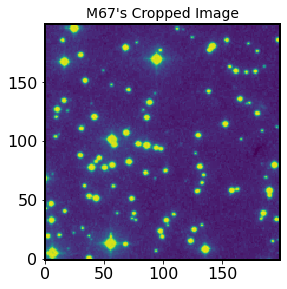

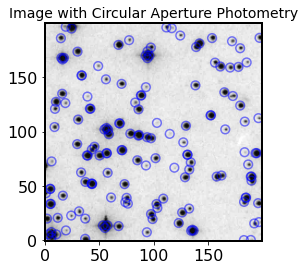

In [6]:
plt.imshow(section_image, origin='lower', interpolation='nearest')
plt.tight_layout()
plt.title("M67's Cropped Image")
plt.show()

plt.imshow(section_image, cmap='gray_r', origin = 'lower')
plt.title("Image with Circular Aperture Photometry")
apertures.plot(color='blue',lw=1.5,alpha=0.5)
plt.show()

### Performing PSF Photometry 

Point Spread Function: describes the flux distribution of a point source throughout a region or aperture. 

The PSF often appears to be like a Gaussian because of: 
- diffraction that happens when light is bent at the edge of the aperture
- lens aberrations that can be chromatic, geometric, or lens imperfections
- image sensing, which can be described as pixels that are gathering light within some area 
    -  We can picture this as the optical image falling on the sensor plane, where the shape of pixel is being convolved with that optical image, and then that is sampled as discrete points

The purpose of performing this on images is to determine the magnitudes and fluxes of stars in crowded fields, such as open and globular clusters (star and galaxy clusters).

#### Example: PSF Photometry to a simulated image containing two stars (one dim and one bright) with a fixed sigma parameter in the  IntegratedGaussianPRF

Note: This should not be done when actually performing PSF photometry of crowded stars in images, since the shape of the PSF, i.e., sigma, should be set by the brightest stars and held fixed when fitting.  

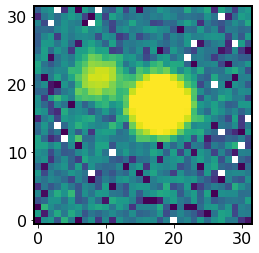

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from photutils.datasets import (make_noise_image,
                                make_gaussian_sources_image)
from astropy.table import Table

from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

sources = Table()
sources['flux'] = [10000, 1000]
sources['x_mean'] = [18, 9]
sources['y_mean'] = [17, 21]
sources['x_stddev'] = [2] * 2
sources['y_stddev'] = sources['x_stddev']
sources['theta'] = [0] * 2
tshape = (32, 32)
image = (make_gaussian_sources_image(tshape, sources)
         + make_noise_image(tshape, distribution='poisson', mean=6.,
                            seed=123)
         + make_noise_image(tshape, distribution='gaussian', mean=0.,
                            stddev=2., seed=123))

vmin, vmax = np.percentile(image, [5, 95])
plt.imshow(image, cmap='viridis', aspect=1, interpolation='nearest',
           origin='lower', norm=LogNorm(vmin=vmin, vmax=vmax))
plt.show()

In [8]:
daogroup = DAOGroup(crit_separation=8)
mmm_bkg = MMMBackground()
iraffind = IRAFStarFinder(threshold=2.5 * mmm_bkg(image), fwhm=4.5)
fitter = LevMarLSQFitter()
gaussian_prf = IntegratedGaussianPRF(sigma=2.05)
gaussian_prf.sigma.fixed = False
itr_phot_obj = IterativelySubtractedPSFPhotometry(finder=iraffind, group_maker=daogroup,
                                                  bkg_estimator=mmm_bkg,
                                                  psf_model=gaussian_prf,
                                                  fitter=fitter, fitshape=(11, 11),
                                                  niters=2)

In [9]:
phot_results = itr_phot_obj(image)

phot_results['id', 'group_id', 'iter_detected', 'x_0', 'y_0', 'flux_0']

phot_results['sigma_0', 'sigma_fit', 'x_fit', 'y_fit', 'flux_fit'] 


sigma_0,sigma_fit,x_fit,y_fit,flux_fit
float64,float64,float64,float64,float64
2.05,1.978347679925341,18.005284165751938,17.008150189196385,9988.054214012222
2.05,1.0952293311837622,18.00684377126767,16.896351342418857,256.84303940543356


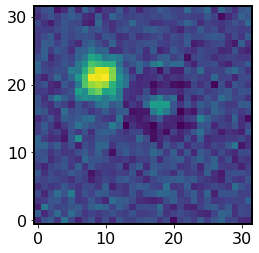

In [10]:
plt.imshow(itr_phot_obj.get_residual_image(), cmap='viridis',
           aspect=1, interpolation='nearest', origin='lower')  
plt.show()


### Applications 

Aperture and PSF photometry can be performed on globular and open cluster images, as well as galaxy cluster images. 

Below is a result of performing photometry on M11, an open cluster, using IRAF and DAOPhot. 

(From a previous class.)

In [11]:
from IPython.display import Image
Image(url= "pic.png", width=400, height=400)

<img src= "Screen Shot 2021-11-30 at 5.45.58 PM.jpg" style = "width:400px;height:400px" />
<img src= "Screen Shot 2021-11-30 at 5.46.20 PM.jpg" style = "width:400px;height:400px" />
<img src= "Screen Shot 2021-11-30 at 5.46.49 PM.jpg" style = "width:400px;height:400px" />

### Extra Example
#### A Simple example with simulated stars whose Point Spread Function is assumed to be Gaussian.



First step is to create an image with four overlapping stars:

In [12]:
from photutils.datasets import (make_noise_image, make_gaussian_sources_image)
from astropy.table import Table
sigma_psf = 2.0
sources = Table()
sources['flux']= [700,800,700,800]
sources['x_mean'] = [12,17,12,17]
sources['y_mean'] = [15,15,20,20]
sources['x_stddev'] = sigma_psf * np.ones(4)
sources['y_stddev'] = sources['x_stddev']
sources['theta'] = [0,0,0,0]
sources['id'] = [1,2,3,4]
tshape = (32,32)
image = (make_gaussian_sources_image(tshape,sources) + 
        make_noise_image(tshape, distribution='poisson',mean = 6., seed =123) +
        make_noise_image(tshape, distribution = 'gaussian', mean = 0.,
                        stddev = 2., seed =123))


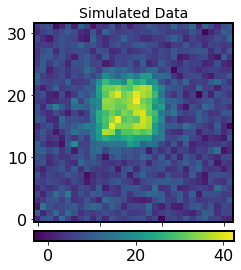

In [13]:
from matplotlib import rcParams
rcParams['font.size'] = 13

plt.imshow(image, cmap='viridis', aspect = 1, interpolation= 'nearest', origin='lower')
plt.title('Simulated Data')
plt.colorbar(orientation = 'horizontal', fraction = 0.046, pad = 0.04)
plt.show()

Then import the required classes to set up a IterativelySubtractedPSFPhotometry object:

In [14]:
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm


Then physically represent and use the objects:

In [15]:
bkgrms = MADStdBackgroundRMS()
std = bkgrms(image)
iraffind = IRAFStarFinder(threshold = 3.5*std,
                         fwhm = sigma_psf * gaussian_sigma_to_fwhm,
                         minsep_fwhm = 0.01, roundhi = 5.0, roundlo= -5.0,
                         sharplo = 0.0, sharphi = 2.0)
daogroup = DAOGroup(2.0 * sigma_psf * gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground() #class to calculate the background in an array using the DAOPHOT MMM algorithm
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma = sigma_psf)

from photutils.psf import IterativelySubtractedPSFPhotometry
photometry = IterativelySubtractedPSFPhotometry(finder = iraffind, group_maker = daogroup,
                                               bkg_estimator = mmm_bkg,
                                               psf_model = psf_model,
                                               fitter = LevMarLSQFitter(),
                                               niters = 1, fitshape = (11,11))
result_tab = photometry(image=image)
residual_image = photometry.get_residual_image()


The parameter values for the finder class (IRAFStarFinder) are completely chosen in an arbitrary manner and optimum values do vary according to the data.

The way to actually do the photometry is by using photometry as a function-like call.

Note: image does not need to be background subtracted. The subtraction is done during the photometry process with the attribute bkg that was used to set up photometry.

Below, the simulated and residual images are compared: 


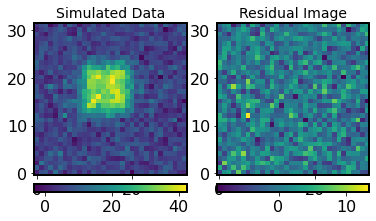

In [16]:
plt.subplot(1,2,1)
plt.imshow(image, cmap ='viridis', aspect =1, interpolation = 'nearest', origin = 'lower')
plt.title('Simulated Data')
plt.colorbar(orientation = 'horizontal', fraction = 0.046, pad = 0.04)
plt.subplot(1,2,2)
plt.imshow(residual_image, cmap = 'viridis', aspect = 1,
          interpolation = 'nearest', origin = 'lower')
plt.title("Residual Image")
plt.colorbar(orientation = 'horizontal', fraction = 0.046, pad = 0.04)
plt.show()